In [839]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
%matplotlib inline

In [890]:
def players_outs(df_in):
    players = {}
    for row in df_in.index:
        rowdict = dict(df_in.loc[row])
        name = rowdict['playerID']
        if name not in players:
            df = pd.DataFrame(columns=['Year', 'Outs Pitched'], index=[1])
            df['Year'] = rowdict['year']
            df['Outs Pitched'] = rowdict['Outs Pitched']
            players[name] = df
        else:
            df = pd.DataFrame(columns=['Year', 'Outs Pitched'], index=[(list(players[name].index)[-1]+1)])
            df['Year'] = rowdict['year']
            df['Outs Pitched'] = rowdict['Outs Pitched']
            players[name] = pd.concat([players[name], df])
    return players
    
def consol(df):
    count = {}
    for row in df.index:
        count[df.loc[row, 'Year']] = 0
    for row in df.index:
        count[df.loc[row, 'Year']] += df.loc[row, 'Outs Pitched']
    result = pd.DataFrame(index=range(df.index[0], len(count)+df.index[0]))
    result['Year'] = count.keys()
    result['Outs Pitched'] = count.values()
    return result

def fill_gaps(df):
    last_year = df.iloc[0]['Year']
    years_to_add = []
    for row in df.index:
        this_year = int(df.loc(row, 'Year'))
        if (this_year - last_year) != 1:
            gap = this_year - last_year
            print(this_year)
            print(last_year)
            for i in range(1, gap):
                years_to_add.append(last_year + 1)
        last_year = this_year
    return years_to_add
        

def tally_outs(df):
    if len(df) <= 1:
        df.loc[1, 'Outs TD Start'] = 0
        df.loc[1, 'Outs TD Finish'] = df.loc[1, 'Outs Pitched']
    else:
        for i, row in enumerate(df.index):
            if i == 0:
                df.loc[row, 'Outs TD Start'] = 0
            else:
                df.loc[row, 'Outs TD Start'] = df.loc[row-1, 'Outs Pitched'] + df.loc[row-1, 'Outs TD Start']
                df.loc[row-1, 'Outs TD Finish'] = df.loc[row, 'Outs TD Start']
        df.iloc[-1, 3] = df.iloc[-1, 2] + df.iloc[-1, 1]
    return df

def season_load(df):
    if len(df) <= 1:
        df.loc[1, 'Mean Outs/Season'] = df.loc[1, 'Outs Pitched']
        df.loc[1, 'Season Load TD'] = 1
        df.loc[1, 'Season Load (Career)'] = 1
    else:
        for row in df.index:
            if row == 1:
                df.loc[1, 'Mean Outs/Season'] = df.loc[1, 'Outs Pitched']
            else:
                df.loc[row, 'Mean Outs/Season'] = df.loc[row, 'Outs TD Start']/(row-1)
            if df.loc[row, 'Mean Outs/Season'] != 0:
                df.loc[row, 'Season Load TD'] = df.loc[row, 'Outs Pitched']/df.loc[row, 'Mean Outs/Season']
            else:
                df.loc[row, 'Season Load TD'] = 1
        total_outs = df.iloc[-1]['Outs TD Finish']
        avg_outs = total_outs/len(df)
        for row in df.index:
            if avg_outs != 0:
                df.loc[row, 'Season Load (Career)'] = df.loc[row, 'Outs Pitched'] / avg_outs
            else:
                df.loc[row, 'Season Load (Career)'] = 1
    return df

def format_names(name_list):
    for name in name_list:
        index = name_list.index(name)
        name = name.lower()
        names = name.split()
        name1 = names[-1]
        if "'" in name1:
            name1 = name1[0] + name1[2:]
        if len(name1) >= 5:
            name1 = name1[0:5]
        name2 = ''
        if names[0][1] == '.':
            name2 = names[0][0] + names[0][2]
        else:
            name2 = names[0][0:2]
        newname = name1 + name2 + '01'
        name_list[index] = newname
    return name_list

def reconcile_names(name_list):
    names_to_reconcile = list(players)
    names_not_found = []
    for i, name in enumerate(name_list):
        while name not in players:
            name_numeral = int(name[-2:])
            name_numeral += 1
            name_numeral = str(name_numeral)
            if len(name_numeral) == 1:
                name_numeral = '0' + name_numeral
            if len(name_numeral) > 2:
                names_not_found.append(name)
                name_numeral = '01'
                name = name[:-2] + name_numeral
                players[name] = pd.DataFrame(index=[1],columns=players['cashnan01'].columns)
                players[name].loc[1] = [2016, 0, 0, 0, 0, 1, 1]
                print('{} was added to players.'.format(name))
            new_name = name[:-2] + name_numeral
            name_list[i] = new_name
            name = new_name
    return name_list


In [891]:
fill_gaps(players['chatwty01'])

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [841]:
pitch = pd.read_csv('./baseballdatabank-2017.1/core/Pitching.csv')

In [842]:
mp = pitch[pitch["yearID"] >= 1989]
pitchers = pd.DataFrame(columns=['playerID', 'year', 'Outs Pitched'])
pitchers['playerID'], pitchers['year'], pitchers['Outs Pitched'] = mp['playerID'], mp['yearID'], mp['IPouts']

In [843]:
players = players_outs(pitchers)

In [844]:
players_to_exclude = []
for player in players:
    ya = list(players[player]['Year']) #ya short for "years active"
    if all([2012 not in ya, 2013 not in ya, 2014 not in ya, 2015 not in ya, 2016 not in ya]):
        players_to_exclude.append(player)

In [845]:
for player in players_to_exclude:
    del players[player]

In [846]:
inj2016 = pd.read_csv('2016_disabled_list.csv')
inj2016_1 = inj2016[inj2016['Position'] == 'RHP']
inj2016_2 = inj2016[inj2016['Position'] == 'LHP']
inj2016 = pd.concat([inj2016_1, inj2016_2]).copy()
inj2016_names = list(inj2016['Name'])
inj2016_names = list(set(inj2016_names))

In [847]:
inj2016_names = format_names(inj2016_names)

In [848]:
inj2015 = pd.read_csv('2015_disabled_list.csv')
inj2015_1 = inj2015[inj2015['Position'] == 'RHP']
inj2015_2 = inj2015[inj2015['Position'] == 'LHP']
inj2015 = pd.concat([inj2015_1, inj2015_2]).copy()
inj2015_names = list(set(inj2015['Name']))

In [849]:
inj2015_names = format_names(inj2015_names)

In [850]:
newly_injured = []
for name in inj2016_names:
    if name not in inj2015_names:
        newly_injured.append(name)

Important exceptions: Rubby de la Rosa is coded "delarru01" in the Lahman set and so was improperly formatted. Zack Jones, Ray Black, and Jessie Biddle are all players who are on the 2016 MLB disabled list but have yet to debut in the big leagues. I'll adjust De La Rosa's name in our injured players to ensure it's properly formatted and remove those who haven't debuted, as (in my mind) they don't count.

In [851]:
newly_injured.remove('rosaru01')
newly_injured.append('delarru01')
newly_injured.remove('jonesza01')
newly_injured.remove('blackra01')
newly_injured.remove('biddlje01')

In [852]:
for player in players:
    players[player] = consol(players[player])
    players[player] = tally_outs(players[player])
    players[player] = season_load(players[player])

In [853]:
newly_injured = reconcile_names(newly_injured)

In [854]:
print(players.keys())

dict_keys(['moyerja01', 'batismi01', 'oliveda02', 'hawkila01', 'isrinja01', 'pettian01', 'riverma01', 'suppaje01', 'hernali01', 'wrighja01', 'carpech01', 'colonba01', 'lowede01', 'millwke01', 'byrdati01', 'chenbr01', 'dempsry01', 'hallaro01', 'pavanca01', 'woodke02', 'burneaj01', 'carlybu01', 'cordefr01', 'doteloc01', 'durbich01', 'farnsky01', 'garcifr02', 'hudsoti01', 'lillyte01', 'motagu01', 'nathajo01', 'ortizra01', 'padilvi01', 'romerjc01', 'wellski01', 'wheelda01', 'wolfra02', 'arroybr01', 'buehrma01', 'choatra01', 'downssc01', 'garlajo01', 'grillja01', 'lopezro01', 'marquja01', 'ohmanwi01', 'pennybr01', 'santajo01', 'vogelry01', 'westbja01', 'zitoba01', 'balfogr01', 'beckejo02', 'beimejo01', 'benoijo01', 'cruzju02', 'dickera01', 'fuentbr01', 'lohseky01', 'lyonbr01', 'macdomi01', 'oswalro01', 'sabatcc01', 'sheetbe01', 'zambrca01', 'affelje01', 'bedarer01', 'cookaa01', 'felicpe01', 'haranaa01', 'lackejo01', 'leecl02', 'lewisco01', 'lidgebr01', 'louxsh01', 'myersbr01', 'peavyja01', 

In [857]:
for name in newly_injured:
    if name not in players:
        print(name)
        

1359

There are a number of players who do not appear in the 2016 season, nor were placed on the disabled list for the first time. This is due to retirement or moving to MiLB in the vast majority of cases. I'll also want to remove players who were inactive for both 2015 and 2016, as I'm looking specifically at previously "healthy" players who joined the 2016 disabled list after a full 2015 season free from disability.

In [863]:
players_to_exclude = []
for player in players:
    if 2016 not in list(players[player]['Year']):
        if player not in newly_injured:
            players_to_exclude.append(player)
            
for player in players_to_exclude:
    del players[player]

In [866]:
len(newly_injured)/len(players)

0.23746701846965698

With the information we've aggregated so far, we can already see that 23.7% of the eligible pitchers, or almost a quarter, have joined the disabled list in 2016 at some point.

In [881]:
print(players['chatwty01'])

   Year  Outs Pitched  Outs TD Start  Outs TD Finish  Mean Outs/Season  \
1  2011           426            0.0           426.0             426.0   
2  2012           194          426.0           620.0             426.0   
3  2013           334          620.0           954.0             310.0   
4  2014            72          954.0          1026.0             318.0   
5  2016           474         1026.0          1500.0             256.5   

   Season Load TD  Season Load (Career)  
1        1.000000              1.420000  
2        0.455399              0.646667  
3        1.077419              1.113333  
4        0.226415              0.240000  
5        1.847953              1.580000  


burnese01
wangch01
leblawa01
smithch07
harrelu01
herrmfr01
kirkmmi01
luebkco01
marinjh01
ondrulo01
woodbl01
chatwty01
cobbal01
diamosc01
phillza01
turneja01
bundydy01
buterdr01
darviyu01
edginjo01
griffaj01
hendeji01
parkebl01
skaggty01
boshebu01
clemepa02
flynnbr01
magilma01
partccu01
rothmi01
ryuhy01
tepesni01
withrch01
buchtry01
escobed02
gimench01
marksju01
rominan01
rowenbe01
simmosh01
adlemti01
alcanra01
altavda01
anderty01
antoldu01
aquinja01
barbajo01
barneda01
barneda02
barneja01
barneto01
barreja01
baumabu01
berrijo01
bethach01
biagijo01
blachty01
blairaa01
bleieri01
boscawi01
bowmama01
bradlje01
braulst01
briceau01
bridwpa01
buschma01
bushma01
cabrema01
campojo01
carasma01
cervehu01
cessalu01
chargjt01
clevimi01
colonjo01
concege01
cottojh01
cuevawi01
curtiza01
danisty01
daytogr01
deanpa02
delacjo01
deleojo03
dermoma01
devench02
diazda01
diazed04
eflinza01
egeco01
eschja01
escobed01
estevca01
flahery01
florody01
fulmeca01
fulmemi01
gamboed01
gantjo01
garnepe01
gartory01
giol

In [867]:
for name in newly_injured:
    if name not in players:
        print(name)

In [872]:
def set_plot(pitchers, names, column, n, year):
    plt.figure(figsize=(16,10))
    length = len(pitchers)
    group_size = length/n
    ranked_values = []
    for pitcher in pitchers:
        df = pitchers[pitcher]
        if year not in list(df['Year']):
            ranked_values.append(0)
        else:
            i = list(df[df['Year']==year].index)[0]
            ranked_values.append(int(df.loc[i, column]))
    ranked_values.sort()
    plt.plot(ranked_values)
    for i in range(0, n):
        plt.axhline(y=(ranked_values[int(group_size * i)]), color='k', linestyle='dashed')
    rank_iter = 1
    for pitcher in pitchers:
        df = pitchers[pitcher]
        i = df[df['Year']==year].index
        if pitcher in names:
                value = int(df.loc[i, column])
                rank = ranked_values.index(value)
                plt.scatter(x=rank, y=value, marker='x')

                
def report(pitchers, names, column, n, year):
    length = len(pitchers)
    group_size = length/n
    ranked_values = []
    for pitcher in pitchers:
        df = pitchers[pitcher]
        if year not in list(df['Year']):
            ranked_values.append(0)
        else:
            i = list(df[df['Year']==year].index)[0]
            ranked_values.append(int(df.loc[i, column]))
    ranked_values.sort()
    groups = {}
    cutoffs = []
    for i in range(0, n):
        groups['group number {}'.format(str(i+1))] = 0
        cutoffs.append(ranked_values[int(group_size * i)])
    for pitcher in names:
        df = pitchers[pitcher]
        value = 0
        if year not in list(df['Year']):
            pass
        else:
            i = df[df['Year']==year].index
            value = int(df.loc[i, column])
            for x in range(0, n):
                if x == 0:
                    if value <= cutoffs[x]:
                        groups['group number {}'.format(x+1)] += 1
                elif 0 < x < (n-1):
                    if cutoffs[x-1] < value <= cutoffs[x]:
                        groups['group number {}'.format(x+1)] += 1
                elif x == (n-1):
                    if cutoffs[x] <= value:
                        groups['group number {}'.format(x+1)] += 1
    for group in groups:
        print('{} has {} in it.'.format(group, groups[group]))
                        
            
    
        

TypeError: cannot convert the series to <class 'int'>

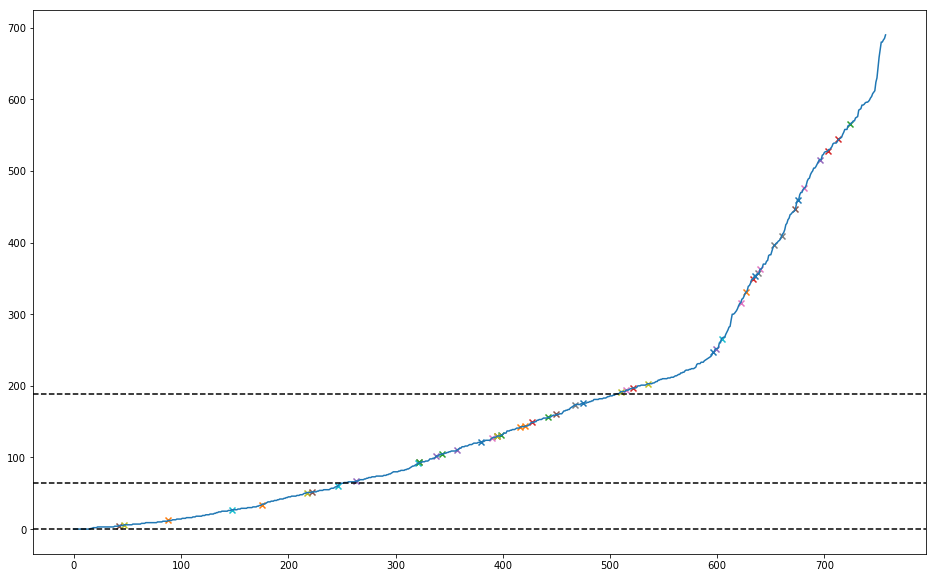

In [873]:
set_plot(players, newly_injured, 'Outs Pitched', 4, 2016)


In [709]:
report(players, newly_injured, 'Outs Pitched', 3, 2015)

KeyError: 'hernafe01'

In [710]:
for player in newly_injured:
    if player not in players:
        print(player)
    

hernafe01
rodrife01
zimmejo01
zimmejo01
mcculla01
mcculla01


In [711]:
for player in newly_injured:
    i = index

['morriaj01',
 'ramosaj01',
 'schugaj01',
 'blairaa01',
 'brookaa01',
 'nolaaa01',
 'nolaaa01',
 'sampsad01',
 'wilsoal01',
 'simonal01',
 'simonal01',
 'bailean01',
 'cashnan01',
 'cashnan01',
 'triggan01',
 'nesbian01',
 'desclan01',
 'swarzan01',
 'vizcaar01',
 'vizcaar01',
 'caminar01',
 'schulbo01',
 'boxbebr01',
 'boxbebr01',
 'boxbebr01',
 'pindebr01',
 'cothaca01',
 'bedroca01',
 'smithca01',
 'smithca01',
 'vargace01',
 'greench01',
 'wangch01',
 'tsaoch01',
 'bassich01',
 'hestoch01',
 'tillmch01',
 'youngch01',
 'lewisco01',
 'reaco01',
 'mulleco01',
 'knebeco01',
 'gearrco01',
 'kimbrcr01',
 'hinojda01',
 'salazda01',
 'odayda01',
 'odayda01',
 'lawde01',
 'storedr01',
 'verhadr01',
 'jacksed01',
 'johnser01',
 'santaer01',
 'hernafe01',
 'rodrife01',
 'montafr01',
 'kontoge01',
 'colege01',
 'colege01',
 'colege01',
 'rondohe01',
 'streehu01',
 'streehu01',
 'barneja01',
 'diazja01',
 'taillja01',
 'hugheja01',
 'ferreje01',
 'manshje01',
 'johnsji01',
 'benoijo01',
 'cham

SyntaxError: unexpected EOF while parsing (<ipython-input-416-af4a2a149d33>, line 7)